# Imports and data setup

In [15]:
# %load_ext autoreload
# %autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from joblib import Parallel, delayed
from sklearn.metrics import confusion_matrix
# from tqdm import tqdm

# # Artisinal, small-batch, handmade modules
# import classification_metrics
from nb_utils import describe

from celltype_utils import SHARED_CELLTYPES, BROAD_TO_COMPARTMENT, broad_to_compartment
from path_constants import top_hit_paths, FIGURE_FOLDER, sig_outdir_base
from plot_constants import get_cmap_color

## Assign figure folder

In [11]:
figure_folder = os.path.join(FIGURE_FOLDER, "kmermaid_classification_metrics")

## Read celltype predictions file

In [2]:
predicted_cells = pd.read_parquet(
    os.path.join(sig_outdir_base, "aggregated-predicted-cells.parquet")
)
describe(predicted_cells)

(84753, 43)
--- First 5 entries ---


,similarity,mouse1_broad_group,search_method,database_type,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,...,bat_narrow_group,bat_broad_group,bat_compartment_group,human_channel,human_cell_ontology_class,human_narrow_group,human_broad_group,human_compartment_group,predicted_compartment,groundtruth_compartment
query_cell_id,,,,,,,,,,,,,,,,,,,,,
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.086712,T cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,None,None,None,None,None,None,None,None,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.119992,T cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,None,None,None,None,None,None,None,None,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.114376,T cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,...,None,None,None,None,None,None,None,None,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGGTGTGGTTT,0.181781,B cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,None,None,None,None,None,None,None,None,lymphoid,lymphoid
MACA_18m_F_LUNG_51__AAACCTGGTGTGGTTT,0.170558,B cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,None,None,None,None,None,None,None,None,lymphoid,lymphoid


In [4]:
predicted_cells.database_type.value_counts()

min-5-percent-shared-kmers-remove-common-kmers    84753
Name: database_type, dtype: int64

# Broad group

## Set `scoring_groupby`, ground truth, and predicted columns

In [5]:
scoring_groupby = ['species', 'database_type', 'search_method', 'alphabet', 'ksize']
ground_truth_celltype_col = 'groundtruth_celltype'
predicted_celltype_col = 'predicted_celltype'

## Compute Confusion matrices

In [9]:

"""
By definition a confusion matrix is such that is equal to the number of 
observations known to be in group and predicted to be in group
"""

top_hit_confusion_dfs = {}

for keys, df in predicted_cells.groupby(
    scoring_groupby
):

    ground_truth = df[ground_truth_celltype_col]
    predicted = df[predicted_celltype_col]
    weight = df["similarity"]
    labels = sorted(list(set(ground_truth) | set(predicted)))

    cm = confusion_matrix(
        ground_truth,
        predicted,
        #         labels=labels,
        #         sample_weight=weight
    )
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.index.name = "ground_truth"
    cm_df.columns.name = "predicted"
    cm_df = cm_df.reindex(index=SHARED_CELLTYPES, columns=SHARED_CELLTYPES)
    #     cm_df = cm_df.loc[SHARED_CELLTYPES, SHARED_CELLTYPES]
    top_hit_confusion_dfs[keys] = cm_df

### Assign confusion matrix folder


In [12]:
broad_confusion_matrix_folder = os.path.join(
    figure_folder, "confusion_matrices", "broad_group"
)
! mkdir -p $broad_confusion_matrix_folder

In [13]:
sns.set_context('paper')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

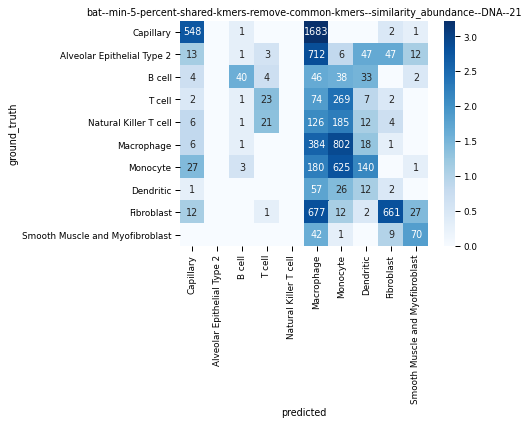

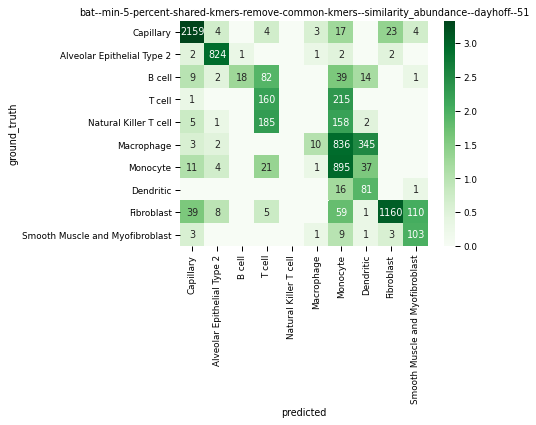

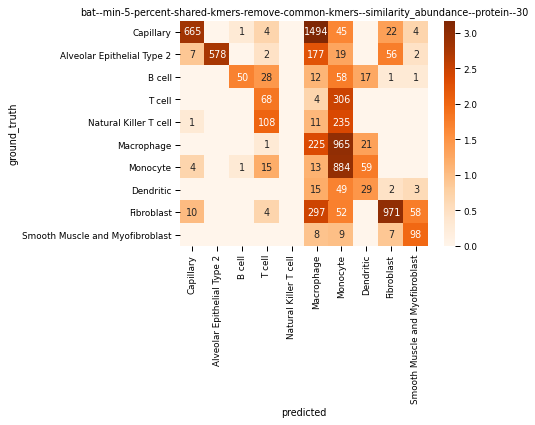

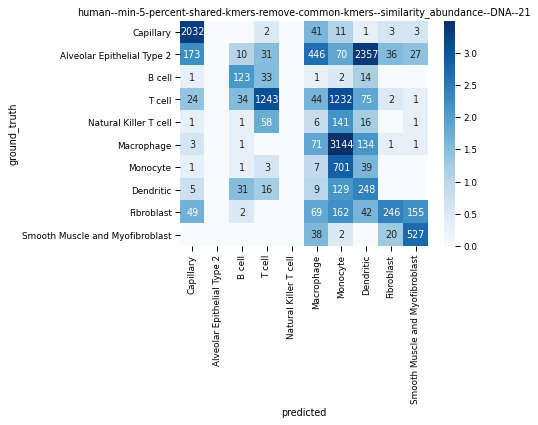

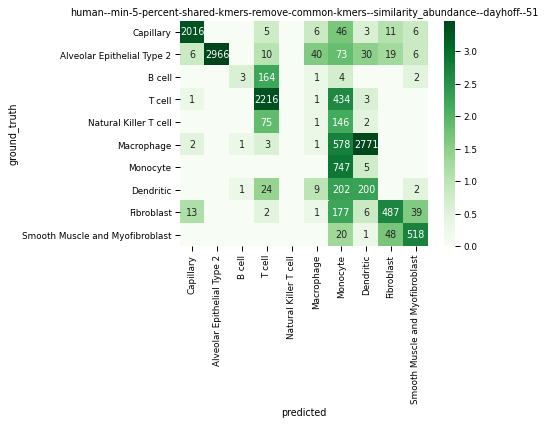

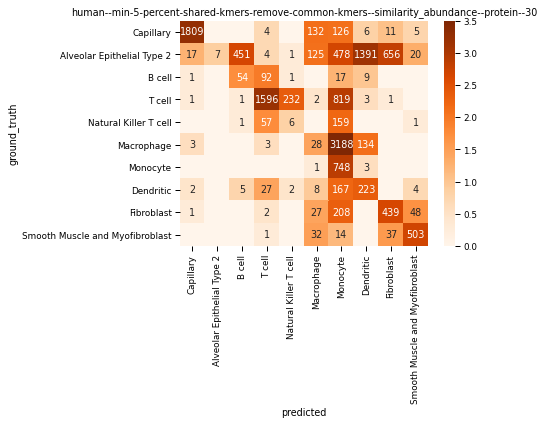

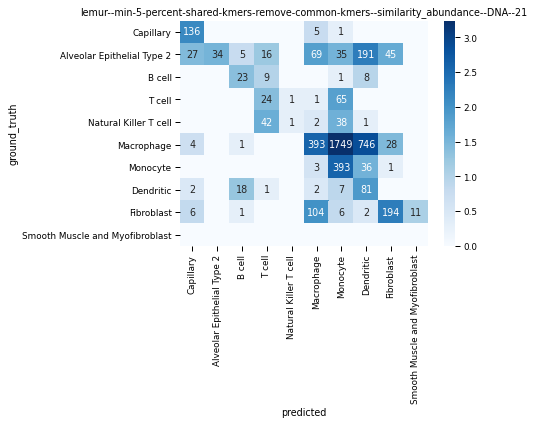

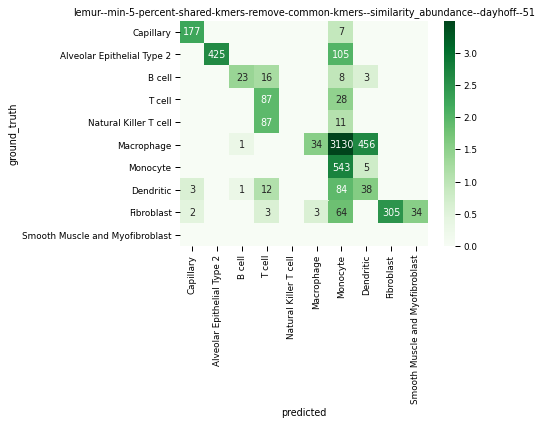

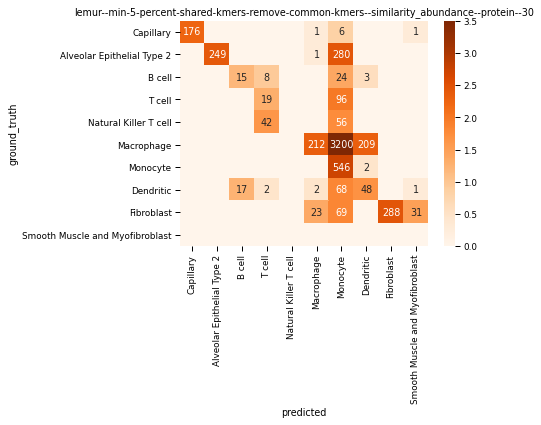

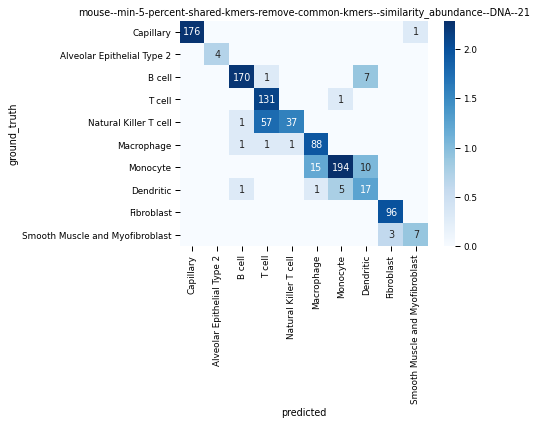

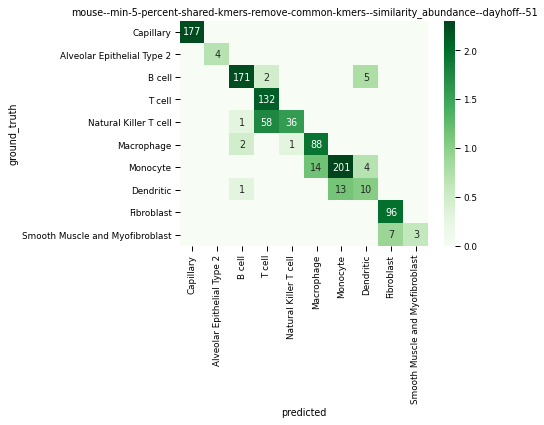

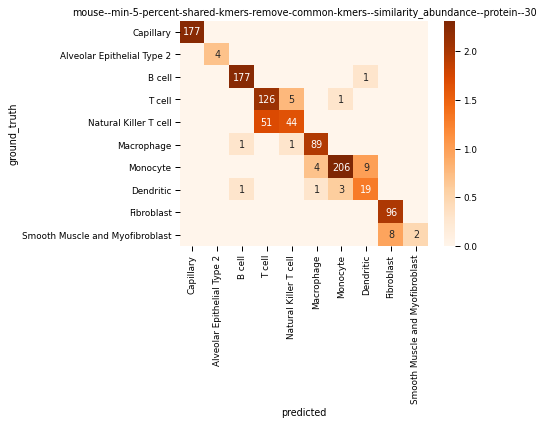

In [16]:
for keys, confusion_df in top_hit_confusion_dfs.items():
#     ksize, alphabet = keys
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # Reorder by compartment
#     index = broad_to_compartment.index.intersection(confusion_df.index)
#     renamer = {broad: f'{broad} ({compartment[:3]})' for broad, compartment in broad_to_compartment[index].items()}
#     confusion_df = confusion_df.loc[index, index]
#     confusion_df = confusion_df.rename(columns=renamer, index=renamer)
    
    
    # Annotate only where nonzero
    annot = confusion_df[confusion_df > 0]
    # Replace all NAs (previously 0s) with an empty string
    annot = annot.applymap(lambda x: '' if pd.isnull(x) else str(int(x)))
#     annot = True
    
    cmap = get_cmap_color(keys)
    sns.heatmap(np.log10(confusion_df + 1), annot=annot, fmt='s', cmap=cmap)
    title = '--'.join(map(str, keys))
    ax.set(title=title)
#     ax.set(title=f"Alphabet: {alphabet}, k-mer size: {ksize}")
    pdf = os.path.join(broad_confusion_matrix_folder, f'{title}.pdf')
    fig.tight_layout()

    fig.savefig(pdf)
    
#     break

# Compartment

## Set `scoring_groupby`, ground truth, and predicted columns

In [24]:
scoring_groupby = ['species', 'database_type', 'alphabet', 'ksize']
ground_truth_celltype_col = 'groundtruth_compartment'
predicted_celltype_col = 'predicted_compartment'

## Compute Confusion matrices

In [25]:
"""
By definition a confusion matrix is such that is equal to the number of 
observations known to be in group and predicted to be in group
"""

compartment_confusion_dfs = {}

for keys, df in predicted_cells.groupby(scoring_groupby):

    ground_truth = df[ground_truth_celltype_col]
    predicted = df[predicted_celltype_col]
    weight = df["similarity"]
    labels = sorted(list(set(ground_truth) | set(predicted)))

    cm = confusion_matrix(
        ground_truth,
        predicted,
        #         labels=labels,
        #         sample_weight=weight
    )
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.index.name = "ground_truth"
    cm_df.columns.name = "predicted"
#     cm_df = cm_df.reindex(index=SHARED_CELLTYPES, columns=SHARED_CELLTYPES)
#     cm_df = cm_df.loc[SHARED_CELLTYPES, SHARED_CELLTYPES]
    compartment_confusion_dfs[keys] = cm_df

### @paper Separately plot confusion matrices to fine tune parameters

In [26]:
compartment_confusion_matrix_folder = os.path.join(
    figure_folder, "confusion_matrices", "compartment_group"
)
! mkdir -p $compartment_confusion_matrix_folder

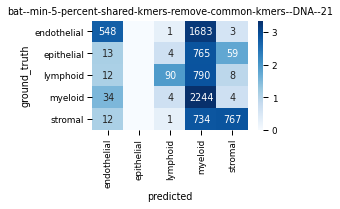

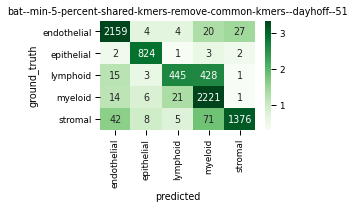

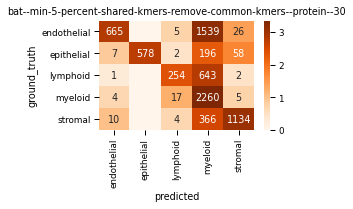

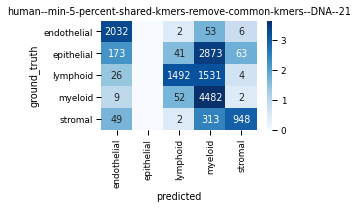

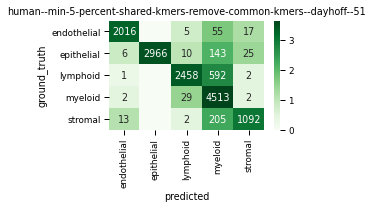

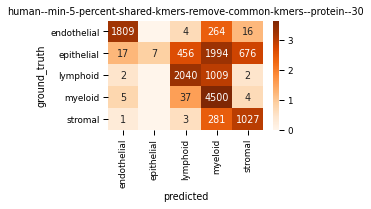

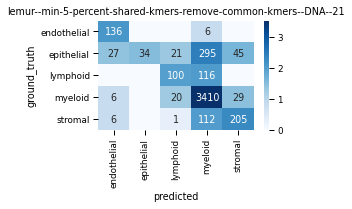

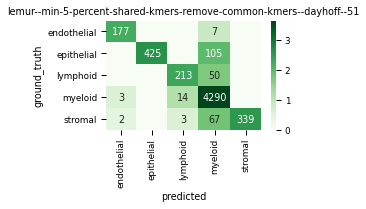

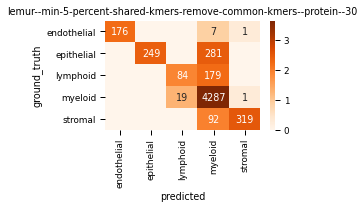

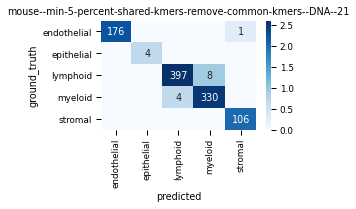

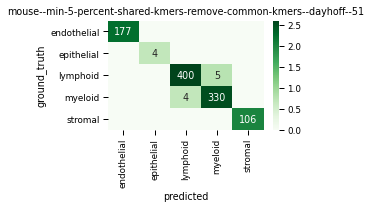

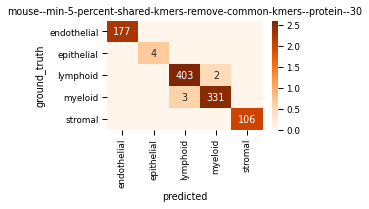

In [27]:

for keys, confusion_df in compartment_confusion_dfs.items():
#     ksize, alphabet = keys
    fig, ax = plt.subplots(figsize=(4, 3))
    
    # Reorder by compartment
#     index = broad_to_compartment.index.intersection(confusion_df.index)
#     renamer = {broad: f'{broad} ({compartment[:3]})' for broad, compartment in broad_to_compartment[index].items()}
#     confusion_df = confusion_df.loc[index, index]
#     confusion_df = confusion_df.rename(columns=renamer, index=renamer)
    
    
    # Annotate only where nonzero
    annot = confusion_df[confusion_df > 0]
    # Replace all NAs (previously 0s) with an empty string
    annot = annot.applymap(lambda x: '' if pd.isnull(x) else str(int(x)))
#     annot = True
    
    cmap = get_cmap_color(keys)
    sns.heatmap(np.log10(confusion_df + 1), annot=annot, fmt='s', cmap=cmap)
    title = '--'.join(map(str, keys))
    ax.set(title=title)
#     ax.set(title=f"Alphabet: {alphabet}, k-mer size: {ksize}")
    pdf = os.path.join(compartment_confusion_matrix_folder, f'{title}.pdf')
    fig.tight_layout()
    fig.savefig(pdf)